**Leonardo Bocchi**

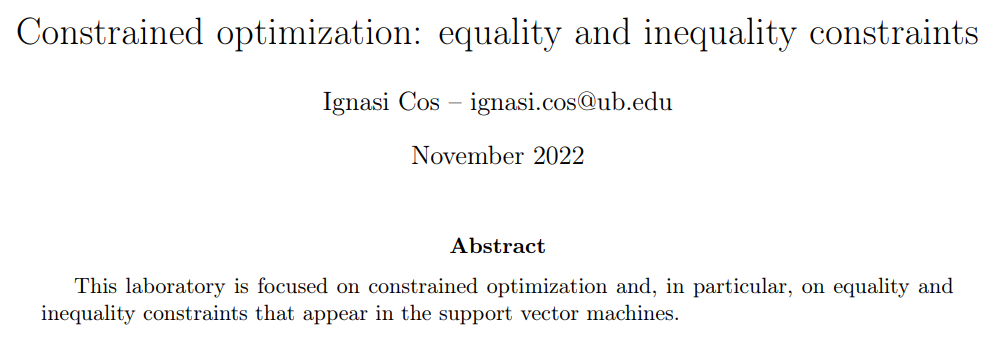

# **Functions to solve problem (9)**

In [61]:
from numpy.linalg import solve, norm

In [62]:
def compose_MKKT(G, A, C, lamb, s):
  ''' compose_MKKT
  Computes the matrix of the KKT system with the given values of s and lambda
  Given G, A, C, s, lamb, Returns the MKKT Matrix
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]

  MKKT = np.block([
                  [G,               -A,              -C,              np.zeros([n,m]) ],
                  [-A.T,            np.zeros([p,p]), np.zeros([p,m]), np.zeros([p,m]) ],
                  [-C.T,            np.zeros([m,p]), np.zeros([m,m]), np.eye(m)       ],
                  [np.zeros([m,n]), np.zeros([m,p]), np.eye(m)*s,     np.eye(m)*lamb  ]
                                                                                      ])
  return MKKT

def update_MKKT(MKKT, lamb, s):
  ''' update_MKKT
  Updates the matrix of the KKT system with the given values of s and lambda
  Given G, A, C, s, lamb, Returns the MKKT Matrix
  '''

  # Retrieve the value of m ----------------------------------------------------
  m = len(s)

  # Update the matrix ----------------------------------------------------------
  MKKT[-m:, -2*m:-m] = np.eye(m)*s
  MKKT[-m:, -m:] = np.eye(m)*lamb
  
  return MKKT

# Define the function to compute alpha for the correction substep --------------
def Newton_step(lamb0, dlamb, s0, ds):
  ''' Newton_step
  This function computes alpha for the step-size correction substep
  Given lamb0, dlamb, s0, ds, returns alpha
  '''
  alp=1
  idx_lamb0=np.array(np.where(dlamb<0))
  if idx_lamb0.size>0:
      alp = min(alp,np.min(-lamb0[idx_lamb0]/dlamb[idx_lamb0]))
  
  idx_s0=np.array(np.where(ds<0))
  if idx_s0.size>0:
      alp = min(alp,np.min(-s0[idx_s0]/ds[idx_s0]))
      
  return alp

def F(G, g, A, b, C, d, z):
  ''' F
  Computes the value of F for the probem with matrices G, g, A, b, C, d
  Given the values of z, Returns the value of F(z) 
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]
  N = n+p+2*m

  # Compose the output vector F(z) ---------------------------------------------
  res = np.zeros([N,1])
  res[:n] = np.dot(G,z[0:n])+g-np.dot(A,z[n:n+p])-np.dot(C,z[n+p:n+p+m])
  res[n:n+p] = b-np.dot(A.T,z[0:n])
  res[n+p:n+p+m] = z[n+p+m:]+d-np.dot(C.T,z[0:n])
  res[n+p+m:] = z[n+p+m:]*z[n+p:n+p+m]

  return res

# Defining a function to run the method ----------------------------------------
def Newton_stepsize_full_S0(G, g, A, b, C, d, x0, gamma0, lamb0, s0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method solves the KKT System using Newton's method with step-size correction
  Given G, g, A, b, C, d, x0, s0, lamb0, Returns the solution to the problem min(1/2*x.T*G*x + g.T*x)
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]
  N = n+p+2*m

  # Initialization -------------------------------------------------------------
  z = np.concatenate((x0, gamma0, lamb0, s0), axis=None).reshape([N,1])
  MKKT = compose_MKKT(G, A, C, lamb0, s0)
  n_iter = 0
  delta = np.ones([N,1])      # Initialized in order to enter the loop, then immediately updated
  mu = 1          # Initialized in order to enter the loop, then updated

  # Method ---------------------------------------------------------------------
  while norm(delta[:n])>epsilon and norm(delta[n:n+m])>epsilon and norm(delta[n+m:])>epsilon and abs(mu)>epsilon and n_iter < max_iter:
    rhv = -F(G, g, A, b, C, d, z)     # Compute the right hand vector
    delta = solve(MKKT, rhv)        # Compute the newton step
    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # compute the value of alpha

    mu = np.dot(z[n+p+m:].T,z[n+p:n+p+m])/m
    mu_tilda = np.dot((z[n+p+m:]+alpha*delta[n+p+m:]).T,z[n+p:n+p+m]+alpha*delta[n+p:n+p+m])/m
    sigma = (mu_tilda/mu)**3

    rhv[n+p+m:] = rhv[n+p+m:]-delta[n+p+m:]*delta[n+p:n+p+m]+sigma*mu*np.ones([m,1])         # Compute the modified right hand vector
    delta = solve(MKKT, rhv)       # Update the newton step
    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # Update the value of alpha

    z = z + 0.95*alpha*delta              # take one step of the method
    MKKT = update_MKKT(MKKT, z[n+p:n+p+m], z[n+p+m:])          # Update the MKKT matrix
    n_iter = n_iter+1

  return z, n_iter

# **Part 5.1**

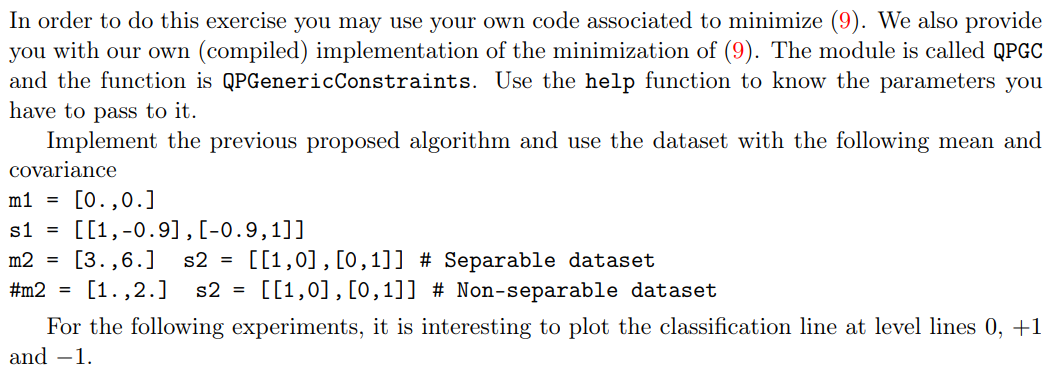

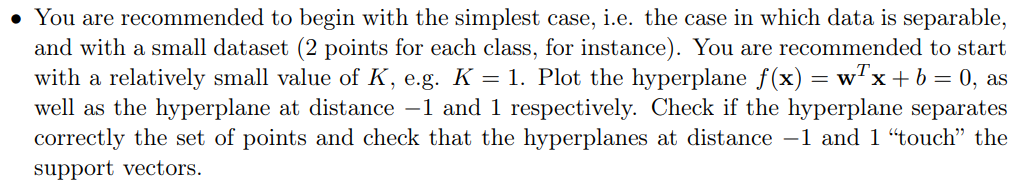

In [63]:
import numpy as np

# Generate the dataset ---------------------------------------------------------
N = 1
x_p = np.random.multivariate_normal([0.,0.], [[1,-0.9],[-0.9,1]], size=N)
x_n = np.random.multivariate_normal([3.,6.], [[1,0],[0,1]], size=N)
print("positive class point: ", x_p)
print("negative class point: ", x_n)

positive class point:  [[ 0.07871242 -0.19882456]]
negative class point:  [[3.57238736 5.78706554]]


In [64]:
# Compose the matrices X and Y -------------------------------------------------
X = np.concatenate((x_p.T.reshape([2,1]), x_n.T.reshape([2,1])), axis=1)
Y = np.diag(np.array([1, -1]))
print(X)
print(Y)

[[ 0.07871242  3.57238736]
 [-0.19882456  5.78706554]]
[[ 1  0]
 [ 0 -1]]


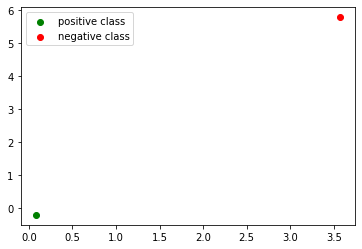

In [65]:
# Plot the dataset -------------------------------------------------------------
plt.figure()
plt.scatter(X[0,0], X[1,0], c='g', label= 'positive class')
plt.scatter(X[0,1], X[1,1], c='r', label='negative class')
plt.legend()

In [66]:
# Define the parameter K -------------------------------------------------------
K = 1

# Define the matrices G, A, C --------------------------------------------------
G = Y.dot((X.T).dot(X.dot(Y)))
A = Y
C = np.block([
              [np.eye(N),     np.zeros([N,N]) ],
              [np.zeros([N,N]), -np.eye(N)    ]
                                              ])


# Retrieve the dimensions of the problem ---------------------------------------
n = G.shape[0]
p = A.shape[1]
m = C.shape[1]

# Define the remaining vectors g, c, d -----------------------------------------
g = -np.ones([n,1])
b = np.zeros([p,1])
d = np.concatenate((np.zeros([N,1]), -K*np.ones([N,1])), axis=0)

# Define other parameters for the method ---------------------------------------
x0 = np.zeros([n,1])
gamma0 = np.ones([p,1])
lamb0 = np.ones([m,1])
s0 = np.ones([m,1])

In [69]:
# Run the method to obtain the alpha_i parameters ------------------------------
z, n_iter = Newton_stepsize_full_S0(G, g, A, b, C, d, x0, gamma0, lamb0, s0)
alpha = z[:2*N]

In [70]:
alpha

array([[0.],
       [0.]])

In [74]:
# Compute the values of w and b of the primal problem --------------------------
w = np.zeros([2*N,1])
for i in range(0, 2*N):
  w = w + alpha[i]*Y[i,i]*X[:,[i]]

b = Y[0,0]-(w.T).dot(X[:,0])

print("w: ", w.T)
print("b: ", b)

w:  [[0. 0.]]
b:  [1.]


# **Part 5.2**

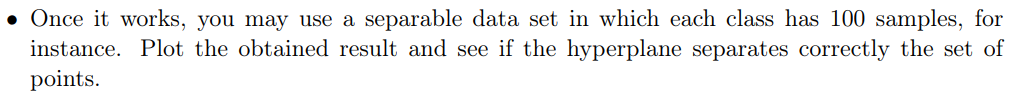

In [53]:
# Generate the dataset ---------------------------------------------------------
N = 100
x_p = np.random.multivariate_normal([0.,0.], [[1,-0.9],[-0.9,1]], size=N)
x_n = np.random.multivariate_normal([3.,6.], [[1,0],[0,1]], size=N)

In [54]:
# Compose the matrices X and Y -------------------------------------------------
X = np.concatenate((x_p.T, x_n.T), axis=1)
Y = np.block([
              [np.eye(N),     np.zeros([N,N]) ],
              [np.zeros([N,N]), -np.eye(N)    ]
                                              ])
print(X.shape)
print(Y.shape)

(2, 200)
(200, 200)


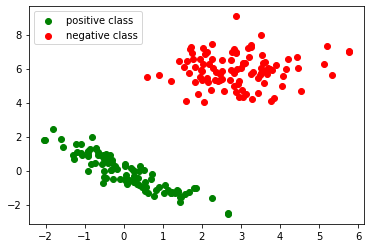

In [55]:
import matplotlib.pyplot as plt

# Plot the dataset -------------------------------------------------------------
plt.figure()
plt.scatter(X[0,:N], X[1,:N], c='g', label= 'positive class')
plt.scatter(X[0,N:], X[1,N:], c='r', label='negative class')
plt.legend()

# **Part 5.3**

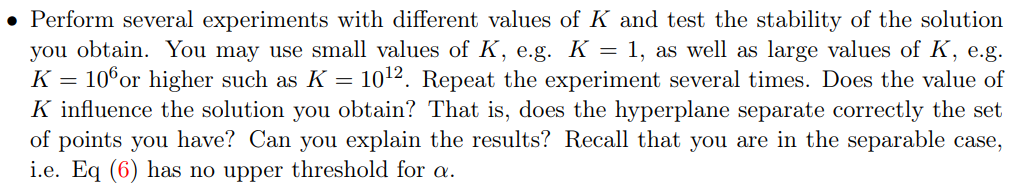

In [ ]:
# Define an array with the values of K that will be tested ---------------------
KK = np.array([1, 5, 10, 100, 1e4, 1e6, 1e12])

# **Part 5.4**

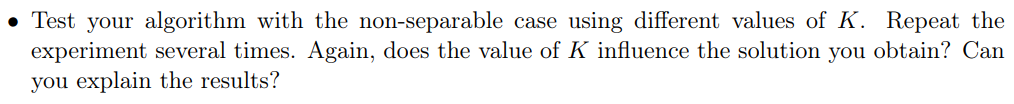

In [56]:
# Generate the dataset ---------------------------------------------------------
N = 100
x_p = np.random.multivariate_normal([0.,0.], [[1,-0.9],[-0.9,1]], size=N)
x_n = np.random.multivariate_normal( [1.,2.], [[1,0],[0,1]], size=N)

In [57]:
# Compose the matrices X and Y -------------------------------------------------
X = np.concatenate((x_p.T, x_n.T), axis=1)
Y = np.block([
              [np.eye(N),     np.zeros([N,N]) ],
              [np.zeros([N,N]), -np.eye(N)    ]
                                              ])
print(X.shape)
print(Y.shape)

(2, 200)
(200, 200)


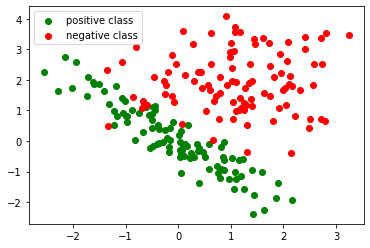

In [58]:
import matplotlib.pyplot as plt

# Plot the dataset -------------------------------------------------------------
plt.figure()
plt.scatter(X[0,:N], X[1,:N], c='g', label= 'positive class')
plt.scatter(X[0,N:], X[1,N:], c='r', label='negative class')
plt.legend()

# **Part 6.1**

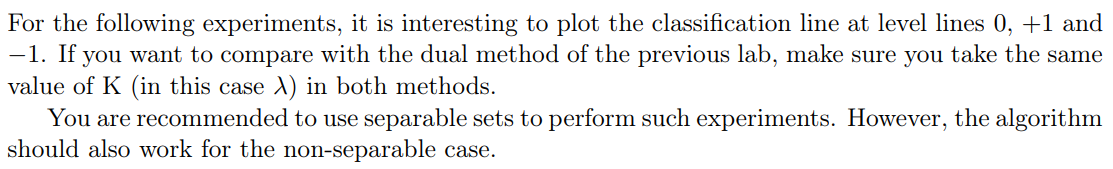

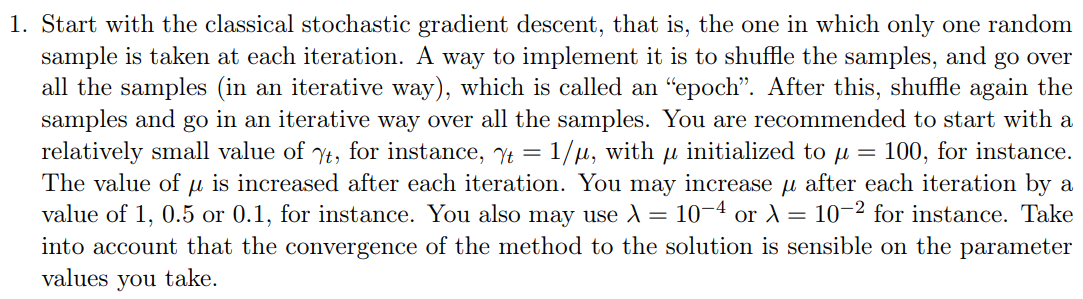

# **Part 6.2**

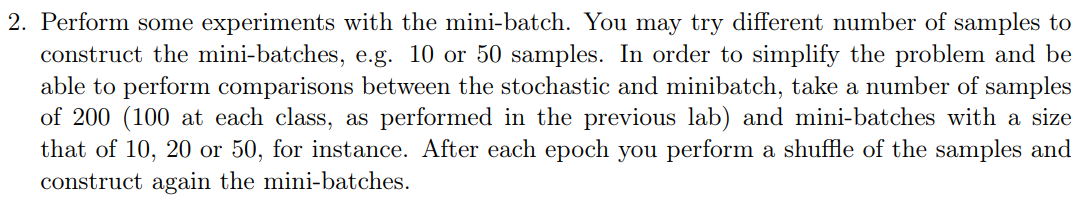

# **Part 6.3**

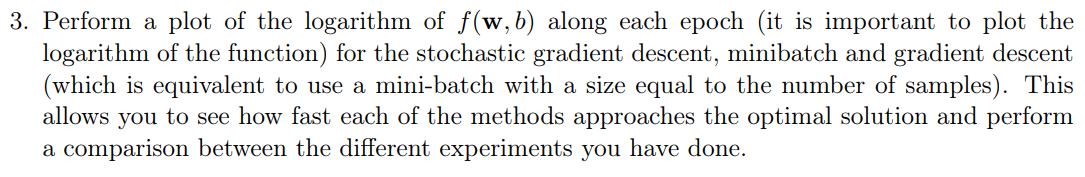